## Week 5 Assignment - Data Exploration and Maps for Group Project
### Creating map of LA Metro+LADOT+Big Blue Bus stops, as well as LA Metro Rail stops overlaid on senior density.
#### Carolyn Pugh

### Import Libraries

In [1]:
#import the libraries I will be using below (pandas, geopandas, matplotlib, contextily)
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import requests
import urllib

### LA City Blockgroup Boundaries

First, I need to import two files containing relevant spatial data - a geojson file showing the boundaries of the City of Los Angeles, since that is our geographic focus. Next, a geojson file that contains block groups for the entire County of Los Angeles, since the file with the City boundary does not contain the block group information.

In [2]:
#reading in the two spatial files and naming dataframes
city_bound = gpd.read_file('City_Boundaries.geojson')
#city_bound has the boundaries of all cities in LA County
blockgroups = gpd.read_file('Census_Block_Groups_2020.geojson')
#blockgroups has hte blockgroup boundaries for all of LA County

The "city_bound" dataframe has all city boundaries in LA, and I only want to look at the City of LA (not Santa Monica, for example). Therefore I only want a subset of this dataframe.

In [3]:
#Querying the city boundary dataframe to create a new LA only boundary.
city_boundLA = city_bound.query("CITY_NAME == 'Los Angeles'").copy()

Next, I will use the "city_boundLA" dataframe to "clip" the LA county blockgroups dataframe, creating a new dataframe that contains blockgroup information for only LA city.

In [4]:
#Using "clip" to create a mask of the block boundary data and cut out everything that is outside LA city.
cityblockgroups = gpd.clip(blockgroups,city_boundLA)

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [5]:
# Save this file because it may be useful for other scripts.
cityblockgroups.to_file('cityblockgroups.geojson')

### Read in LA Metro Bus Route Data

In [6]:
#read in Metro bus lines geojson file and create dataframe
metrobusroute = gpd.read_file('Metro_Bus_Lines.geojson')

In [7]:
#What columns does it have?
metrobusroute.columns.to_list()

['OBJECTID',
 'VAR_ROUTE',
 'VAR_IDENT',
 'VAR_DESCR',
 'VAR_DIREC',
 'MetroCategory',
 'MetroBusType',
 'RouteNumber',
 'RouteName',
 'TOOLTIP',
 'NLA_URL',
 'geometry']

I will rename some of these columns to make it more obvious what they represent.

In [8]:
#Renaming columns for clarity
metrobusroute.rename(columns=
               {'VAR_ROUTE':'Trunk Line',
 'VAR_IDENT':'Identifying Number',
 'VAR_DESCR':'Trip Pattern',
 'MetroCategory': 'Metro Category',
 'MetroBusType':'Metro Bus Type',
 'RouteNumber': 'Route Number',
 'RouteName': 'Route Name'}, inplace = True)
#Displaying first 2 rows as a check
metrobusroute.head(2)

,OBJECTID,Trunk Line,Identifying Number,Trip Pattern,VAR_DIREC,Metro Category,Metro Bus Type,Route Number,Route Name,TOOLTIP,NLA_URL,geometry
0,1,603,N1,END TO END,0,ComCirc,Metro Shuttles and Circulators,603,603 Glendale-Grand Sta Via San Fernando-Rampar...,603 Glendale-Grand Sta Via San Fernando-Rampar...,http://www.metro.net/riding/maps/?nla_target=1...,"LINESTRING (-118.26462 34.03322, -118.26432 34..."
1,2,603,S1,END TO END,1,ComCirc,Metro Shuttles and Circulators,603,603 Glendale-Grand Sta Via San Fernando-Rampar...,603 Glendale-Grand Sta Via San Fernando-Rampar...,http://www.metro.net/riding/maps/?nla_target=1...,"LINESTRING (-118.26088 34.14528, -118.26088 34..."


### Read in LA Metro Bus Stop Data - "Stops Serving Lines"
#### Each stop contains data for each line served by that stop. This will be important for our analysis of what stops are accessible to block groups with high densities of senior residents.

In [9]:
#Read in file for LA Metro Bus Stops and name a new dataframe, metrobusstops
metrobusstops = gpd.read_file('StopServingLines1022.shp')

In [10]:
#Renaming columns for clarity
metrobusstops.rename(columns=
               {'STOPNUM':'StopNumber',
 'STOPNAME':'StopName'}, inplace = True)
#Displaying first 5 rows as a check
metrobusstops.head()

,StopNumber,StopName,LAT,LONG,LINE_DIR1,LINE_DIR2,LINE_DIR3,LINE_DIR4,LINE_DIR5,LINE_DIR6,LINE_DIR7,LINE_DIR8,LINE_DIR9,LINE_DIR10,LINE_DIR11,LINE_DIR12,LINE_DIR13,LINE_DIR14,geometry
0,1,Paramount / Slauson,33.973248,-118.113113,108-E,265-S,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.11311 33.97325)
1,3,Jefferson / 10th,34.025471,-118.328402,35-N,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.32840 34.02547)
2,6,120th / Augustus F Hawkins,33.924696,-118.242222,53-N,120-W,55-N,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.24222 33.92470)
3,7,120th / Martin Luther King Hospital,33.924505,-118.240369,55-S,120-E,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.24037 33.92451)
4,12,15054 Sherman Way,34.201075,-118.461953,162-E,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-118.46195 34.20108)


### Pulling in LA DOT Bus Route and Stop Data

LA DOT provided data in six shapefiles, one file for routes and one for stops for three different bus types

LA DOT Community Dash:

In [11]:
#Read in file for LA DOT Community Dash Bus Stops and Routes
communitydash_stops = gpd.read_file('LA_DOT_data/geo_export_16a65b67-8914-4be6-b080-e03f9fdd23a6.shp')
communitydash_route = gpd.read_file('LA_DOT_data/geo_export_6a5115bd-2818-4cdd-bd10-d8ea258b75b7.shp')

In [12]:
#first row of community dash stop as check
communitydash_stops.head(1)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
0,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,89.0,Beachwood Canyon,BC,298831.0,Beachwood & Westshire (Southbound),2401.0,Stop: Beachwood & Westshire (Southbound)\nStop...,POINT (-118.32111 34.11968)


<AxesSubplot: >

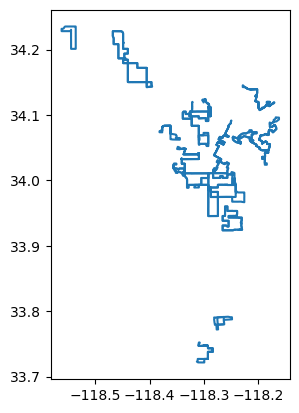

In [13]:
#plot routes for community dash as check
communitydash_route.plot()

LA DOT Commuter Express:

In [14]:
#Read in file for LA DOT Commuter Express Bus Stops and Routes
commuterexpress_route = gpd.read_file('LA_DOT_data/geo_export_1b588cc2-b98f-42a6-8207-e6df6af67c22.shp')
commuterexpress_stops = gpd.read_file('LA_DOT_data/geo_export_6d784597-ba4b-4a1a-8e74-4ca9e9758280.shp')

<AxesSubplot: >

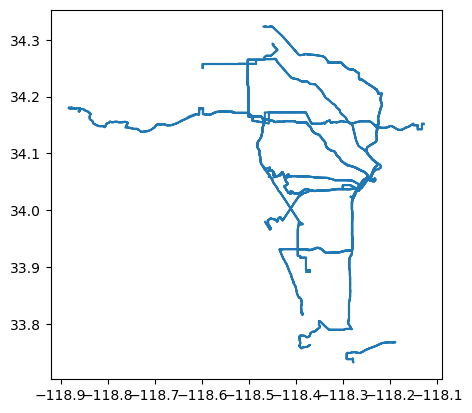

In [15]:
#plot routes for Commuter Express as check
commuterexpress_route.plot()

In [16]:
#first row of Commuter Express stop as check
commuterexpress_stops.head(1)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
0,http://www.ladotbus.com/simple/regions/8/route...,8.0,Commuter Express,12.0,CE142 - Long Beach,CE142 - Long Beach,431166.0,Ports O'Call & Sampson Way,8800.0,Stop: Ports O'Call & Sampson Way\nStop No: 880...,POINT (-118.27780 33.73204)


LA DOT Downtown DASH

In [17]:
#Read in file for LA DOT downtown dash files
downtowndash_route = gpd.read_file('LA_DOT_data/geo_export_247776de-aafe-44c0-9cbd-03d1931ad720.shp')
downtowndash_stops = gpd.read_file('LA_DOT_data/geo_export_d09ae2e0-bede-462e-996d-3f4e9eb096e2.shp')

In [18]:
#first row of downtown dashs stop as check
downtowndash_stops.head(1)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
0,http://www.ladotbus.com/simple/regions/6/route...,6.0,Downtown Dash,40.0,Route A,A,91421.0,7th & Bixel (Westbound),6153.0,Stop: 7th & Bixel (Westbound)\nStop No: 6153\n...,POINT (-118.26400 34.05081)


<AxesSubplot: >

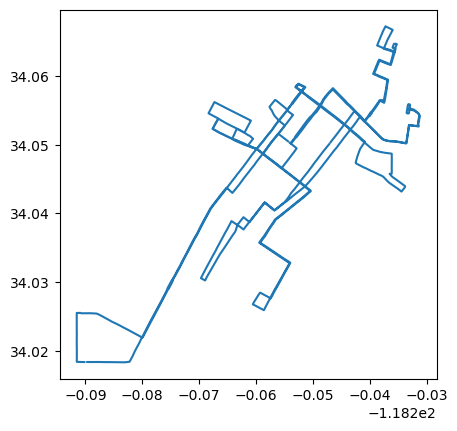

In [19]:
#plot routes for downtown dash as check
downtowndash_route.plot()

### Getting Big Blue Bus Data

In [20]:
#read in shapefile and create dataframe
BBB_stops = gpd.read_file('BigBlueBusdata/stops.shp')
#print first row as check
BBB_stops.head(1)

,stop_id,stop_code,stop_name,stop_desc,geometry
0,1145,2768,SUNSET EB & MARQUEZ PL FS,17100 W SUNSET BLVD & MARQUEZ AVE,POINT (-118.54889 34.04185)


<AxesSubplot: >

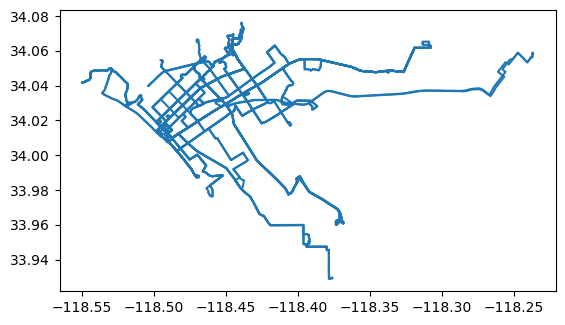

In [21]:
#read in routes shapefile and create dataframe
BBB_routes = gpd.read_file('BigBlueBusdata/shapes.shp')
#plot as check
BBB_routes.plot()

### Clipping Dataframes to get only LA City

I will use the LA city boundary dataframe to create new dataframes for both bus routes and bus stops that are specific to the City.

In [22]:
#Using "clip" to create a mask of the city boundary data and cut out bus stops that are outside the LA city boundary.
citymetrostops = gpd.clip(metrobusstops,city_boundLA)

In [23]:
#Using "clip" to create a mask of the city boundary data and cut out bus route data that is outside the LA city boundary.
citybusroute = gpd.clip(metrobusroute,city_boundLA)

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [24]:
#First I need to edit the CRS of LA DOT datasets to match that of the rest of my datasets.
communitydash_stops = communitydash_stops.to_crs(4326)
communitydash_route = communitydash_route.to_crs(4326)
commuterexpress_route = commuterexpress_route.to_crs(4326)
commuterexpress_stops = commuterexpress_stops.to_crs(4326)
downtowndash_route = downtowndash_route.to_crs(4326)
downtowndash_stops = downtowndash_stops.to_crs(4326)

In [25]:
#Clipping community DASH bus dataframes to include only LA City
community_citydot_stops = gpd.clip(communitydash_stops,city_boundLA)
community_citydot_route = gpd.clip(communitydash_route,city_boundLA)
#Clipping Commuter DASH bus dataframes to include only LA City
commuter_citydot_route = gpd.clip(commuterexpress_route,city_boundLA)
commuter_citydot_stops = gpd.clip(commuterexpress_stops,city_boundLA)
#Clipping Downtown DASH bus dataframes to include only LA City
downtown_citydot_route = gpd.clip(downtowndash_route,city_boundLA)
downtown_citydot_stops = gpd.clip(downtowndash_stops,city_boundLA)

In [26]:
#Clipping Big Blue Bus dataframe to include only LA city stops
BBB_stops_city = gpd.clip(BBB_stops, city_boundLA)
BBB_routes_city = gpd.clip(BBB_routes, city_boundLA)

### Adding in LA Metro Rail Data

Import LA metro stop data

In [27]:
#import the Data 
metrorailstops = gpd.read_file('MetroRailStopsdata/Metro_Rail_Lines_Stops.geojson')
#clip to city boundaries
citymetrorailstops = gpd.clip(metrorailstops,city_boundLA)

### Now I will create a dataframe with all bus and metro stops.

Let's start with LA DOT, and combine the different dataframes. 

In [28]:
#try to create dataframe with all the transit stop data, starting with LA DOT
#append community dash to commuter express and create new dataframe
data = [community_citydot_stops, commuter_citydot_stops]
df2 = pd.concat(data)
#append downtown dash to new dataframe
data2 = [df2, downtown_citydot_stops]
LADOTcitystops = pd.concat(data2)
#check by displaying sample rows
LADOTcitystops.sample(6)

,nla_url,region,regiontype,routeid,routename,routenames,stopid,stopname,stopnumber,tooltip,geometry
195,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,91.0,Crenshaw Counter-clockwise,CCC,303065.0,Hillcrest & Pinafore St.,1140.0,Stop: Hillcrest & Pinafore St.\nStop No: 1140\...,POINT (-118.34751 34.01284)
671,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,90.0,Leimert / Slauson Clockwise,LS C,305491.0,Crenshaw & Stocker St.,1146.0,Stop: Crenshaw & Stocker St.\nStop No: 1146\nR...,POINT (-118.33503 34.00875)
1500,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,10.0,Watts Clockwise,Watts,356657.0,Avalon Blvd & 104th St (Northbound),5414.0,Stop: Avalon Blvd & 104th St (Northbound)\nSto...,POINT (-118.26507 33.94177)
1636,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,89.0,Wilshire / Koreatown Clockwise,WKC,306026.0,Western & James M Wood Blvd. (CW),2865.0,Stop: Western & James M Wood Blvd. (CW)\nStop ...,POINT (-118.30902 34.05571)
133,http://www.ladotbus.com/simple/regions/8/route...,8.0,Commuter Express,12.0,CE409B - Sunland,CE409B - Sunland,433877.0,Broadway & Alpine St (Northbound),8065.0,Stop: Broadway & Alpine St (Northbound)\nStop ...,POINT (-118.23836 34.06217)
1000,http://www.ladotbus.com/simple/regions/7/route...,7.0,Community Dash,11.0,Panorama City/ Van Nuys Counterclockwise,PC/VN CCW,393282.0,Sepulveda Blvd & Roscoe Blvd Southbound,3112.0,Stop: Sepulveda Blvd & Roscoe Blvd Southbound\...,POINT (-118.46786 34.22103)


This looks good. Now I will try to combine it with Big Blue Bus data. I need to think about what columns does Big Blue Bus data have, how does it compare to LADOT, and what do I need from each?

In [29]:
#what columns does Big Blue Bus data have, how does it compare to LADOT, and what do I need from each?
BBB_stops_city

,stop_id,stop_code,stop_name,stop_desc,geometry
102,38,2010,AVIATION/LAX STATION,11600 UNNAMED ST,POINT (-118.37625 33.92950)
82,529,2187,AVIATION NB & IMPERIAL FS,11300 AVIATION BLVD & E IMPERIAL HWY,POINT (-118.37838 33.93121)
194,616,2238,CENTURY EB & AVIATION NS,5500 W CENTURY BLVD & LOS ANGELES COUNTY METRO...,POINT (-118.37904 33.94538)
748,532,2190,CENTURY WB & AVIATION FS,5600 W CENTURY BLVD & LOS ANGELES COUNTY METRO...,POINT (-118.37883 33.94564)
618,1671,3112,98TH EB & AVION FS,0 W 98TH ST & AVION DR,POINT (-118.38964 33.94728)
...,...,...,...,...,...
722,1099,2552,BARRINGTON NB & TERRYHILL FS,600 S BARRINGTON AVE & TERRYHILL PL,POINT (-118.46819 34.05812)
626,1101,2554,BARRINGTON SB & 400 BK (REC CTR) MB,400 S BARRINGTON AVE & BARRINGTON CT,POINT (-118.46861 34.06162)
625,1100,2553,BARRINGTON NB & 400 BL (REC CTR) NS,400 S BARRINGTON AVE & BARRINGTON CT,POINT (-118.46847 34.06227)
191,140,2048,BARRINGTON SB & SUNSET FS,100 S BARRINGTON AVE & BARRINGTON CT,POINT (-118.46966 34.06479)


For the purposes of this exercise, I really only need stop name, stop ID, and geometry. 

Refining columns for LADOT data:

In [30]:
#get column names
LADOTcitystops.columns.to_list()

['nla_url',
 'region',
 'regiontype',
 'routeid',
 'routename',
 'routenames',
 'stopid',
 'stopname',
 'stopnumber',
 'tooltip',
 'geometry']

In [31]:
#list columns to keep
columnstokeep = ['stopid','stopname','geometry']
#create new dataframe
LADOTcitystops1 = LADOTcitystops[columnstokeep]
#print
LADOTcitystops1

,stopid,stopname,geometry
1632,355358.0,Anaheim St & Fries Ave (Eastbound),POINT (-118.26526 33.77972)
1600,354962.0,Anaheim St & Fries Ave (Westbound),POINT (-118.26511 33.77990)
1599,354957.0,Anaheim St & Avalon Blvd (Westbound),POINT (-118.26279 33.78001)
1633,355370.0,Avalon Blvd & Anaheim St (Northbound),POINT (-118.26237 33.78030)
1634,355380.0,Avalon Blvd & Opp St (Northbound),POINT (-118.26256 33.78272)
...,...,...,...
60,42384.0,Chinatown Gold Line Station (Westbound),POINT (-118.23595 34.06367)
61,42387.0,Hill & College,POINT (-118.23858 34.06469)
64,42392.0,Broadway & Gin Ling Way,POINT (-118.23686 34.06529)
62,42388.0,Hill & Gin Ling Way,POINT (-118.23805 34.06577)


Refining columns for Big Blue Bus

In [32]:
#list columns to keep
columnstokeep1 = ['stop_id','stop_name','geometry']
#create new dataframe
BBB_stops_city1 = BBB_stops_city[columnstokeep1]
#print
BBB_stops_city1

,stop_id,stop_name,geometry
102,38,AVIATION/LAX STATION,POINT (-118.37625 33.92950)
82,529,AVIATION NB & IMPERIAL FS,POINT (-118.37838 33.93121)
194,616,CENTURY EB & AVIATION NS,POINT (-118.37904 33.94538)
748,532,CENTURY WB & AVIATION FS,POINT (-118.37883 33.94564)
618,1671,98TH EB & AVION FS,POINT (-118.38964 33.94728)
...,...,...,...
722,1099,BARRINGTON NB & TERRYHILL FS,POINT (-118.46819 34.05812)
626,1101,BARRINGTON SB & 400 BK (REC CTR) MB,POINT (-118.46861 34.06162)
625,1100,BARRINGTON NB & 400 BL (REC CTR) NS,POINT (-118.46847 34.06227)
191,140,BARRINGTON SB & SUNSET FS,POINT (-118.46966 34.06479)


In [33]:
#rename columns to match LADOT
BBB_stops_city1 = BBB_stops_city1.rename(columns={'stop_id': 'stopid', 'stop_name': 'stopname'})
BBB_stops_city1

,stopid,stopname,geometry
102,38,AVIATION/LAX STATION,POINT (-118.37625 33.92950)
82,529,AVIATION NB & IMPERIAL FS,POINT (-118.37838 33.93121)
194,616,CENTURY EB & AVIATION NS,POINT (-118.37904 33.94538)
748,532,CENTURY WB & AVIATION FS,POINT (-118.37883 33.94564)
618,1671,98TH EB & AVION FS,POINT (-118.38964 33.94728)
...,...,...,...
722,1099,BARRINGTON NB & TERRYHILL FS,POINT (-118.46819 34.05812)
626,1101,BARRINGTON SB & 400 BK (REC CTR) MB,POINT (-118.46861 34.06162)
625,1100,BARRINGTON NB & 400 BL (REC CTR) NS,POINT (-118.46847 34.06227)
191,140,BARRINGTON SB & SUNSET FS,POINT (-118.46966 34.06479)


Refine columns for Metro Bus Data

In [34]:

#list columns to keep
columnstokeep3 = ['StopNumber','StopName','geometry']
#create new dataframe
citymetrostops1 = citymetrostops[columnstokeep3]
#rename columns to match LADOT
citymetrostops1 = citymetrostops1.rename(columns={'StopNumber': 'stopid', 'StopName': 'stopname'})
#print
citymetrostops1

,stopid,stopname,geometry
8715,14560,Shepard / Carolina,POINT (-118.29049 33.70711)
8263,13800,Pacific / Shepard,POINT (-118.28810 33.70719)
3392,5407,Pacific / 39th,POINT (-118.28778 33.70858)
8277,13816,Pacific / 38th,POINT (-118.28808 33.70936)
8276,13815,Pacific / 36th,POINT (-118.28808 33.71127)
...,...,...,...
6471,10561,Foothill / Cobalt,POINT (-118.45191 34.32329)
287,451,Bledsoe / Gladstone,POINT (-118.44484 34.32341)
6480,10572,Bledsoe / Gladstone,POINT (-118.44478 34.32374)
2299,3714,Olive View UCC,POINT (-118.45306 34.32399)


Last time! Now realizing I should have made this a loop.  Doing the same thing for metro rail stops.

In [35]:
#list columns to keep
columnstokeep4 = ['Station','StopNumber','geometry']
#create new dataframe
citymetrorailstops1 = citymetrorailstops[columnstokeep4]
#rename columns to match LADOT
citymetrorailstops1 = citymetrorailstops1.rename(columns={'StopNumber': 'stopid', 'Station': 'stopname'})
#switch order of stopid and name to match other dataframes
citymetrorailstops1 = citymetrorailstops1.iloc[:,[1,0,2]]
#display
citymetrorailstops1.head(1)

,stopid,stopname,geometry
10,80113,103rd Street / Watts Towers Station,POINT (-118.24316 33.94222)


Finally, combining all the public transit stops into one dataframe.

In [36]:
#append LADOT to LA Metro bus stops
data = [LADOTcitystops1, citymetrostops1]
df7 = pd.concat(data)
#append Big Blue Bus data to new dataframe
data5 = [df7, BBB_stops_city1]
citybus_stops = pd.concat(data5)
#append metro rail data
data8 = [citybus_stops, citymetrorailstops1]
transit_stops = pd.concat(data8)
#print as check
transit_stops.head(2)

,stopid,stopname,geometry
1632,355358.0,Anaheim St & Fries Ave (Eastbound),POINT (-118.26526 33.77972)
1600,354962.0,Anaheim St & Fries Ave (Westbound),POINT (-118.26511 33.77990)


Yay! Now I have a dataframe with all the public transit stops, including their ID, name, and geometry.

<AxesSubplot: >

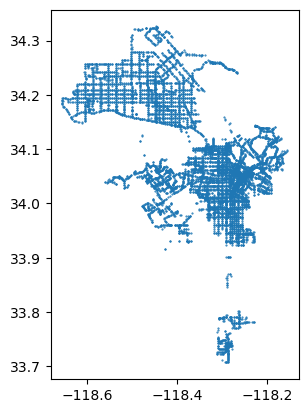

In [37]:
#plot as check
transit_stops.plot(marker='.',markersize=1)

Create Plot Of Senior Population Density vs. Transit Stop Locations

In [38]:
#Pull in the senior population density dataframe from Lucy's data cleaning work.
seniors=gpd.read_file('Senior_Pop_Density.geojson')
seniors.head()

,BG20,ShapeSTArea,FIPS,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Square Miles,Pop Density,geometry
0,2742023,1.045276e+06,060372742023,0,0,13,13,0.403581,32.0,"POLYGON ((-118.46464 33.97641, -118.46508 33.9..."
1,2739025,5.131686e+06,060372739025,120,38,0,158,1.981346,80.0,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713..."
2,2739024,1.861628e+06,060372739024,90,10,0,100,0.718775,139.0,"POLYGON ((-118.46565 33.97974, -118.46587 33.9..."
3,2739023,1.218168e+06,060372739023,92,137,11,240,0.470335,510.0,"POLYGON ((-118.46315 33.98615, -118.46310 33.9..."
4,2735023,4.868382e+06,060372735023,29,40,0,69,1.879684,37.0,"POLYGON ((-118.47672 33.98746, -118.47506 33.9..."


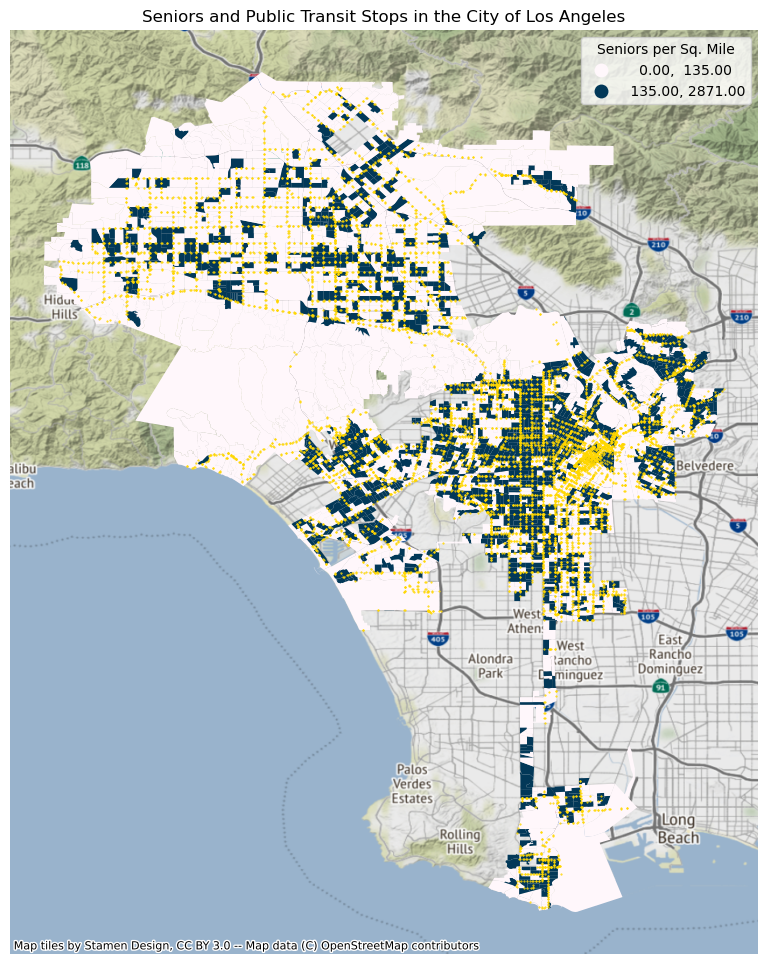

In [39]:
#Plot Bus Stops and Metro Stops on top of Senior Population Density
fig,ax = plt.subplots(figsize=(12,12))
ax1=seniors.plot(ax=ax,column='Pop Density',scheme='quantiles',k=2,legend=True,cmap='PuBu',
              legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
               'title': 'Seniors per Sq. Mile'
            }),
#plot LA metro bus stops
ax2=transit_stops.plot(ax=ax,marker='.',markersize=1,legend=True,color='gold')

#Format plot.
ax.axis('off')
ax.set_title('Seniors and Public Transit Stops in the City of Los Angeles')
ctx.add_basemap(ax, crs=4326)


### Trying to get a metric of density of transit stops/block group

In [40]:
#What is the best column indentifier for a block group?
cityblockgroups.head()

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
2456,2457,2742023,274202,BG 3,1.045276e+06,4082.112116,"POLYGON ((-118.46464 33.97641, -118.46508 33.9..."
2449,2450,2739025,273902,BG 5,5.131686e+06,9166.983856,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713..."
2448,2449,2739024,273902,BG 4,1.861628e+06,6284.133027,"POLYGON ((-118.46565 33.97974, -118.46587 33.9..."
2447,2448,2739023,273902,BG 3,1.218168e+06,4851.582209,"POLYGON ((-118.46315 33.98615, -118.46310 33.9..."
2435,2436,2735023,273502,BG 3,4.868382e+06,10124.770714,"POLYGON ((-118.47672 33.98746, -118.47506 33.9..."


I will use "BG20" as my block group unique identifier. 

In [41]:
#join transit data with cityblockgroup data
transit_bg = gpd.sjoin(cityblockgroups,transit_stops)
#display
transit_bg.sample(3)

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,index_right,stopid,stopname
1424,1425,2074001,207400,BG 1,9.358166e+06,15170.871790,"POLYGON ((-118.23805 34.05107, -118.23971 34.0...",1521,2519.0,Main / 1st
1834,1835,2282102,228210,BG 2,2.186582e+06,5944.820064,"POLYGON ((-118.25214 34.00665, -118.25290 34.0...",3003,4854.0,Central / 41st
684,685,1320013,132001,BG 3,3.485625e+06,7920.740483,"POLYGON ((-118.50986 34.19388, -118.51111 34.1...",9154,15241.0,Vanowen / White Oak


In [42]:
#Use valuecounts to get the number of unique stops per block group
transit_bg_count= transit_bg.value_counts(['BG20']).reset_index(name='stop_count')
#display
transit_bg_count.head()

,BG20,stop_count
0,2074001,177
1,2077122,79
2,2079021,67
3,2240201,53
4,2077111,49


Now I have a dataframe that has the number of transit stops per block group.

In [43]:
#Basic statistics on the number of transit stops/block group
transit_bg_count.describe()

,stop_count
count,2274.000000
mean,4.500000
std,6.000165
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,177.000000


array([[<AxesSubplot: title={'center': 'stop_count'}>]], dtype=object)

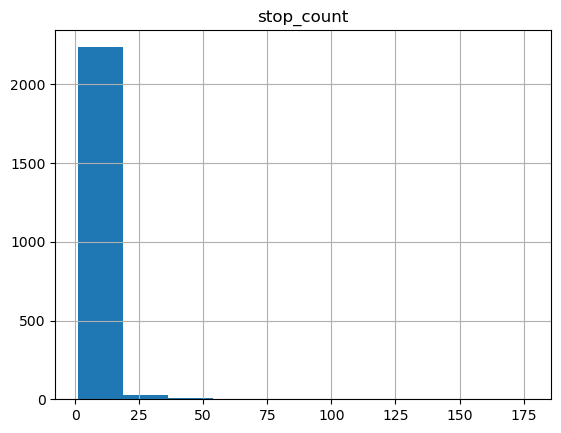

In [44]:
#plot a histogram
transit_bg_count.hist(bins=10)

What block group has 177 stops? Is that accurate?

In [45]:
#find the block group ID where # of stops = 177(max)
transit_bg_count.loc[transit_bg_count['stop_count'] == 177]

,BG20,stop_count
0,2074001,177


In [46]:
#find the block group ID where # of stops = NaN
transit_bg_count.loc[transit_bg_count['stop_count'] == '0']

,BG20,stop_count


In [47]:
#find the geography of that block group
some_values = ['2074001']
maxbg = transit_bg.loc[transit_bg['BG20'].isin(some_values)]
maxbg.head(1)

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,index_right,stopid,stopname
1424,1425,2074001,207400,BG 1,9.358166e+06,15170.87179,"POLYGON ((-118.23805 34.05107, -118.23971 34.0...",6424,10493.0,1st / Judge John Aiso


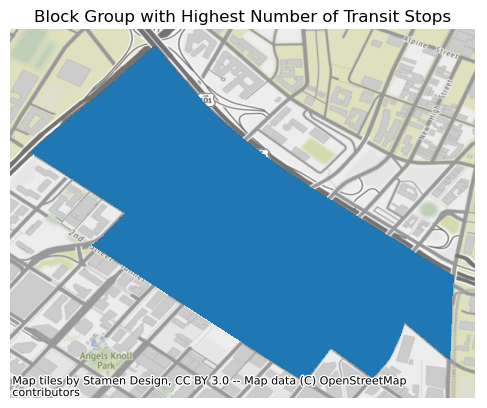

In [48]:
#plot it
fig,ax = plt.subplots(figsize=(6,6))
ax1=maxbg.plot(ax=ax)

#Format plot.
ax.axis('off')
ax.set_title('Block Group with Highest Number of Transit Stops')
ctx.add_basemap(ax, crs=4326)

This is right in downtown Los Angeles, so it does make sense as the block group with the most transit stops.

I want to add transit_bg_count back to my larger dataframe so that I have the spatial data included. 

In [49]:
#Join transit_bg_count with ciytblockgroups
transit_bg_count_new = transit_bg_count.merge(cityblockgroups, on='BG20',how='left')

In [50]:
#print sample
transit_bg_count_new.sample(2)

,BG20,stop_count,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
464,1232061,6,461,123206,BG 1,6.488594e+06,10269.807148,"POLYGON ((-118.37033 34.19032, -118.37178 34.1..."
1748,2211101,2,1746,221110,BG 1,1.017681e+06,4050.496298,"POLYGON ((-118.28856 34.04626, -118.28855 34.0..."


In [51]:
#change ShapeStArea datatype to int
transit_bg_count_new['ShapeSTArea'] = transit_bg_count_new['ShapeSTArea'].astype('int')
#create column for density of transit stops
transit_bg_count_new['stopdensity'] = transit_bg_count_new['ShapeSTArea']/transit_bg_count_new['stop_count']
#print as check
transit_bg_count_new.head(2)

,BG20,stop_count,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,stopdensity
0,2074001,177,1425,207400,BG 1,9358165,15170.871790,"POLYGON ((-118.23805 34.05107, -118.23971 34.0...",52870.988701
1,2077122,79,1432,207712,BG 2,2738696,6782.687349,"POLYGON ((-118.25446 34.04591, -118.25500 34.0...",34667.037975


In [52]:
#check for null values
transit_bg_count_new['stopdensity'].isnull().values.any()

False

In [53]:
transit_bg_count_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 2273
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   BG20           2274 non-null   object  
 1   stop_count     2274 non-null   int64   
 2   OBJECTID       2274 non-null   int64   
 3   CT20           2274 non-null   object  
 4   LABEL          2274 non-null   object  
 5   ShapeSTArea    2274 non-null   int64   
 6   ShapeSTLength  2274 non-null   float64 
 7   geometry       2274 non-null   geometry
 8   stopdensity    2274 non-null   float64 
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 177.7+ KB


In [54]:
#change density datatype to int
transit_bg_count_new['stopdensity'] = transit_bg_count_new['stopdensity'].astype('int')

In [55]:
#Basic statistics on the density of transit stops/block group
transit_bg_count_new.describe()

,stop_count,OBJECTID,ShapeSTArea,ShapeSTLength,stopdensity
count,2274.000000,2274.000000,2.274000e+03,2274.000000,2.274000e+03
mean,4.500000,1363.575638,4.707169e+06,8998.465135,1.687712e+06
std,6.000165,861.885992,1.474003e+07,6918.626498,1.041414e+07
min,1.000000,2.000000,2.306660e+05,2059.690684,2.819300e+04
25%,2.000000,682.250000,1.752579e+06,5839.678273,4.862285e+05
50%,3.000000,1355.500000,2.667465e+06,7469.002372,8.676690e+05
75%,5.000000,1964.750000,4.202385e+06,9741.448554,1.516737e+06
max,177.000000,6587.000000,4.761975e+08,155767.638460,4.761975e+08


Now I want to create some charts to look at stop density across block groups. I will start by making a column that indicates which block groups are below the average stop density (mean stop density = 1.687713e+06)

In [56]:
#creating a list to look at average stop density
avgstopdensity = []
for row in transit_bg_count_new['stopdensity']:
        if row < 1.687713e+06:    avgstopdensity.append('below_mean')
        elif row > 1.687713e+06:   avgstopdensity.append('above_mean')
        
        else:          avgstopdensity.append('NaN')

In [57]:
#how many block groups have below average stop density?
avgstopdensity.count('below_mean')

1782

1782 block groups have below average transit stop density - that is too many to look at, so I am going to look at percentiles instead.

In [58]:
#creating a list to look at percentiles of stop density
perstopdensity = []
for row in transit_bg_count_new['stopdensity']:
        if row < 4.862288e+05:    perstopdensity.append(25)
        elif row > 8.676696e+05:   perstopdensity.append(50)
        elif row > 1.516737e+06:   perstopdensity.append(75)
        elif row > 4.761975e+08:   perstopdensity.append(100)
        
        else:          perstopdensity.append('NaN')

In [59]:
#how many block groups are in the top 25% of stop density?
perstopdensity.count(25)

569

This is more useable, I will go with the bottom quartile for my analysis. I will join this list as a column to my dataframe.

In [60]:
transit_bg_count_new['percentile_stopdensity'] = perstopdensity
transit_bg_count_new.head(2)

,BG20,stop_count,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,stopdensity,percentile_stopdensity
0,2074001,177,1425,207400,BG 1,9358165,15170.871790,"POLYGON ((-118.23805 34.05107, -118.23971 34.0...",52870,25
1,2077122,79,1432,207712,BG 2,2738696,6782.687349,"POLYGON ((-118.25446 34.04591, -118.25500 34.0...",34667,25


In [61]:
#I realized there was an eaiser way to look at this by subsetting the dataframe 
top25 = transit_bg_count_new[transit_bg_count_new["stopdensity"] < 4.862288e+05]
top25.head(3)

,BG20,stop_count,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,stopdensity,percentile_stopdensity
0,2074001,177,1425,207400,BG 1,9358165,15170.871790,"POLYGON ((-118.23805 34.05107, -118.23971 34.0...",52870,25
1,2077122,79,1432,207712,BG 2,2738696,6782.687349,"POLYGON ((-118.25446 34.04591, -118.25500 34.0...",34667,25
2,2079021,67,1435,207902,BG 1,6744683,11059.851331,"POLYGON ((-118.25723 34.03457, -118.25828 34.0...",100666,25


Now I have a dataframe of only the bottom 25% of transit stop density blockgroups.


In [62]:
#Get the BG20 identifiers from this datframe as a series.
highdensityBG = top25['BG20']
highdensityBG

0       2074001
1       2077122
2       2079021
3       2240201
4       2077111
         ...   
2002    2073062
2039    2119221
2045    2124102
2046    2124103
2081    1899032
Name: BG20, Length: 569, dtype: object

In [63]:
#create dataframe of spatial data of bottom 25% transit density block groups. 
highdensityBGdf = transit_bg.loc[transit_bg['BG20'].isin(highdensityBG)]
highdensityBGdf.head(1)

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,index_right,stopid,stopname
2456,2457,2742023,274202,BG 3,1.045276e+06,4082.112116,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",7618,12686.0,Pacific / Driftwood


I'm going to repeat this process for the low density tranit block groups.

In [64]:
low25 = transit_bg_count_new[transit_bg_count_new["stopdensity"] > 1.516737e+06]
low25.head(3)

,BG20,stop_count,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,stopdensity,percentile_stopdensity
5,9800281,45,6579,980028,BG 1,211924310,85718.579965,"POLYGON ((-118.44701 33.95176, -118.44656 33.9...",4709429,50
17,9800241,27,6576,980024,BG 1,89196152,46246.894948,"POLYGON ((-118.46955 34.17926, -118.46917 34.1...",3303561,50
40,9800091,18,6561,980009,BG 1,228869386,81127.024463,"POLYGON ((-118.30627 34.16024, -118.30504 34.1...",12714965,50


In [65]:
#Get the BG20 identifiers from this datframe as a series.
lowdensityBG = low25['BG20']
lowdensityBG

5       9800281
17      9800241
40      9800091
41      1133032
50      9800081
         ...   
2269    1241041
2270    1241023
2271    2324021
2272    2324022
2273    9800381
Name: BG20, Length: 569, dtype: object

In [66]:
#create dataframe of spatial data of top 25% transit density block groups. 
lowdensityBGdf = transit_bg.loc[transit_bg['BG20'].isin(lowdensityBG)]
lowdensityBGdf.head(1)

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,index_right,stopid,stopname
2448,2449,2739024,273902,BG 4,1.861628e+06,6284.133027,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",599,424404.0,Pacific Ave & Washington Blvd (Arriving)


Plotting Density of Transit Stops:

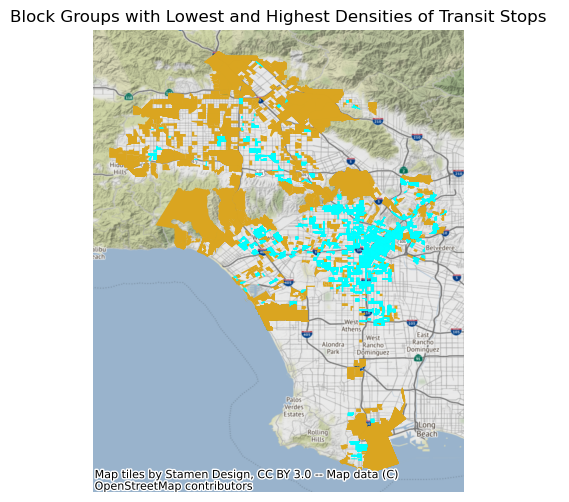

In [67]:
#plot it
fig,ax = plt.subplots(figsize=(6,6))
ax1=lowdensityBGdf.plot(ax=ax, color='goldenrod', label = 'Bottom Quartile')
ax2 = highdensityBGdf.plot(ax=ax, color='blue', label = 'Top Quartile')

# Add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys())
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
#ax.legend([ax1,ax2])
ax.set_title('Block Groups with Lowest and Highest Densities of Transit Stops')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)